In [1]:
import sys
!"{sys.executable}" -m pip install openai-whisper language-tool-python librosa torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 12.6 MB/s eta 0:00:00 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.1/253.1 MB 6.3 MB/s eta 0:00:000:00:0100:01
  Created wheel for openai-whisper: filename=openai_whisper-20240930-py3-none-any.whl size=803405 sha256=71d68307546707780adc4636d6a75c7d20822549606ee4c1ae6b23cc138e7209
  Stored in directory: /root/.cache/pip/wheels/dd/4a/1f/d1c4bf3b9133c8168fe617ed979cab7b14fe381d059ffb9d83
Successfully built openai-whisper


In [2]:
import os
import pandas as pd
import numpy as np
import librosa
import whisper
import language_tool_python
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm

In [3]:
TRAIN_CSV = r"/kaggle/input/grammar-scorer/grammar-scoring-engine/train.csv"
TEST_CSV = r"/kaggle/input/grammar-scorer/grammar-scoring-engine/test.csv"
TRAIN_AUDIO_DIR = r"/kaggle/input/grammar-scorer/grammar-scoring-engine/train"
TEST_AUDIO_DIR = r"/kaggle/input/grammar-scorer/grammar-scoring-engine/test"

In [4]:
#  Load Data
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

In [5]:
print(train_df.columns)


Index(['filename', 'label'], dtype='object')


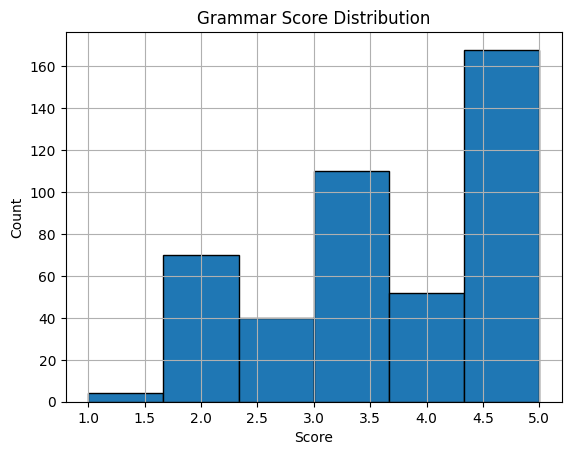

In [6]:
#  Visualize Score Distribution
train_df['label'].hist(bins=6, edgecolor='black')
plt.title("Grammar Score Distribution")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

In [7]:
# Load Whisper ASR Model
asr_model = whisper.load_model("base") 


100%|███████████████████████████████████████| 139M/139M [00:02<00:00, 59.2MiB/s]
/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

In [8]:
tool = language_tool_python.LanguageTool('en-US')

In [9]:
# Feature Extraction
def extract_features(audio_path):
    result = asr_model.transcribe(audio_path)
    text = result['text']

    y, sr = librosa.load(audio_path, sr=16000)
    duration = librosa.get_duration(y=y, sr=sr)

    matches = tool.check(text)
    num_errors = len(matches)
    words = text.split()
    num_words = len(words)
    num_sentences = text.count('.') + text.count('!') + text.count('?')

    return {
        'text': text,
        'duration': duration,
        'num_words': num_words,
        'grammar_errors': num_errors,
        'error_rate': num_errors / max(num_words, 1),
        'words_per_sec': num_words / max(duration, 1),
        'sentence_count': num_sentences,
        'avg_word_length': np.mean([len(w) for w in words]) if words else 0
    }


In [10]:
#  Process Training Data
train_features = []
for row in tqdm(train_df.itertuples(), total=len(train_df)):
    path = os.path.join(TRAIN_AUDIO_DIR, row.filename)
    feats = extract_features(path)
    feats['file'] = row.filename
    feats['score'] = row.label   
    train_features.append(feats)

train_feats_df = pd.DataFrame(train_features)


  0%|          | 0/444 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
  0%|          | 1/444 [00:31<3:55:52, 31.95s/it]/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
  0%|          | 2/444 [00:38<2:03:37, 16.78s/it]/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
  1%|          | 3/444 [00:53<1:58:02, 16.06s/it]/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
  1%|          | 4/444 [01

In [11]:
# Train Regression Model
X = train_feats_df.drop(columns=['file', 'score', 'text'])
y = train_feats_df['score']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [12]:
# Evaluate
val_preds = model.predict(X_val)
rmse = mean_squared_error(y_val, val_preds, squared=False)
mae = mean_absolute_error(y_val, val_preds)

print(f"Validation RMSE: {rmse:.3f}")
print(f"Validation MAE: {mae:.3f}")

Validation RMSE: 1.058
Validation MAE: 0.878


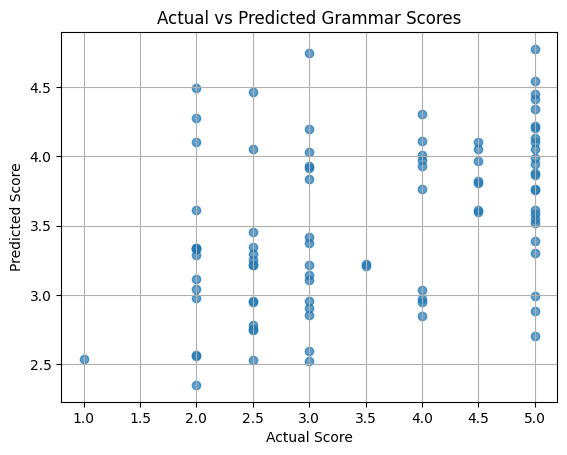

In [13]:
# Visualize Predictions
plt.scatter(y_val, val_preds, alpha=0.7)
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Actual vs Predicted Grammar Scores")
plt.grid(True)
plt.show()


In [15]:
# Process Test Data
test_features = []
for row in tqdm(test_df.itertuples(), total=len(test_df)):
    path = os.path.join(TEST_AUDIO_DIR, row.filename)
    feats = extract_features(path)
    feats['file'] = row.filename
    test_features.append(feats)

test_feats_df = pd.DataFrame(test_features)
X_test = test_feats_df.drop(columns=['file', 'text'])
test_preds = model.predict(X_test)


  0%|          | 0/195 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
  1%|          | 1/195 [01:00<3:16:18, 60.72s/it]/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
  1%|          | 2/195 [01:07<1:33:39, 29.12s/it]/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
  2%|▏         | 3/195 [01:16<1:03:18, 19.78s/it]/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
  2%|▏         | 4/195 [01

In [20]:

SUBMISSION_PATH = "/kaggle/working/submission.csv"


submission = pd.DataFrame({
    'filename': test_feats_df['file'],
    'label': test_preds
})


submission.to_csv(SUBMISSION_PATH, index=False)


print(f" Submission file saved to: {SUBMISSION_PATH}")
print(submission.head())


if os.path.exists(SUBMISSION_PATH):
    print(" File saved successfully.")
else:
    print(" File not saved.")


 Submission file saved to: /kaggle/working/submission.csv
         filename  label
0   audio_706.wav  3.015
1   audio_800.wav  2.570
2    audio_68.wav  3.510
3  audio_1267.wav  3.405
4   audio_683.wav  2.845
 File saved successfully.
